In [1]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random
from random import shuffle

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty

In [5]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [6]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [7]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [8]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

In [9]:
def flaring(B, length, frequency=0, amplitude=1):   
    global flareMag
    np.linspace(0,np.log(8),length)
    fouriers = np.linspace(1,3000,length)
    logF = [np.log(x) for x in fouriers]
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    #imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,length, length)
    minutes = [x for x in seconds]
    plt.show()
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT]
    normalised = [x/(np.mean(positive)) for x in positive]
    flareMag = [amplitude * x for x in normalised]
    return flareMag

In [10]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [39]:
def lombScargleAuto(frequencyRange,objectmag,numsteps=100000,modulationAmplitude=0.1,background=40,Nquist=200): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power, mag, error
    totperiod = []
    totmperiod = []
    totpower = [] # reset

    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        actualperiod = []
        measuredperiod = []
        measuredpower = [] # reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            fig, ax = plt.subplots()

            ax.plot(periods, power)
            #plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            #maxpos = [i for i, j in enumerate(power) if j == power.max()]
            #LSperiod = (periods[maxpos])
            period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]

#             plt.plot(phase, mag, 'o')
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.show()
#             print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min()),# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
            
            actualperiod.append(1/(frequencyRange[frange]*0.01))
            measuredperiod.append(period)
            measuredpower.append(power.max())
        
        totperiod.append(actualperiod)
        totmperiod.append(measuredperiod)
        totpower.append(measuredpower)

In [57]:
def lombScargle(frequencyRange,objectmag,loopNo=10,df=0.001,fmin=0.001,numsteps=100000,modulationAmplitude=0.1,background=40,Nquist=200): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error
    totperiod = []
    totmperiod = []
    totpower = [] # reset
    freqs = fmin + df * np.arange(numsteps) # for manuel
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        actualperiod = []
        measuredperiod = []
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            power = model.score_frequency_grid(fmin, df, numsteps)  
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
#             model = LombScargleFast().fit(date, mag, error) # auto 
#             periods, power = model.periodogram_auto(nyquist_factor=Nquist) # auto 
#             model.optimizer.period_range=(0.01, 10) # auto 
#             LSperiod = model.best_period # auto 
            
            fig, ax = plt.subplots()
            ax.plot(1./freqs, power)
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]

#             plt.plot(phase, mag, 'o')
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min()),# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
                  
            actualperiod.append(1/(frequencyRange[frange]*0.01))
            measuredperiod.append(np.mean(LSperiod))
            measuredpower.append(power.max())
            maxpower = []
            
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                periods, power = model.periodogram_auto(nyquist_factor=Nquist)
                model.optimizer.period_range=(0.01, 10)
                maxpower.append(power.max())
            print(maxpower)
            counter =0
            for X in range(0, len(maxpower)):
                if maxpower[X] > power.max():
                    counter = counter + 1 
            print(maxpower)
            SigPercent = (1-(counter/len(maxpower)))*100
            print(SigPercent)
        
        totperiod.append(actualperiod)
        totmperiod.append(measuredperiod)
        totpower.append(measuredpower)

In [13]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)

[(0.032362658477917382-0.01164158956658254j),
 (0.076744470966533612+0.05671855439093481j),
 (0.10950023138439369+0.013238737516415307j),
 (0.083646922608184682-0.016869372557070099j),
 (0.087136844651643508+0.058014880586460815j),
 (0.14062786446195677-0.0018364476442533585j),
 (0.11670413724535339-0.021552455425377696j),
 (0.079222417821349103-0.0078715201983508808j),
 (0.084602398454619379+0.049130038102536772j),
 (0.10888003069442161-0.014384369374804232j),
 (0.12873631574217523-0.019519813800939138j),
 (0.08438277029508276+0.0098237462290352712j),
 (0.069258800290892486+0.010765421144432609j),
 (0.10442367280130052+0.02695609348981038j),
 (0.12884893582970403+0.0097395118713769022j),
 (0.095737492163213131+0.020217533129867179j),
 (0.15571397511749269+0.038159696859219883j),
 (0.12751482367855832-0.022407799312954727j),
 (0.10358763707510042-0.025253144191403315j),
 (0.14861203122867425+0.015135428789254219j),
 (0.11903942973950346-0.040469219920799458j),
 (0.11933529657240441-0.0

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


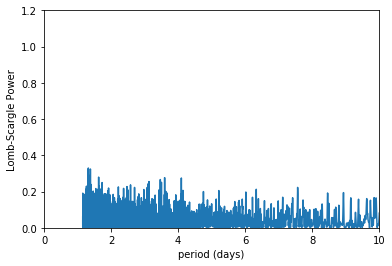

('actualperiod', 0.6666666666666666, 'measured period', 0.013775844616278735, 1.1506398937931026) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


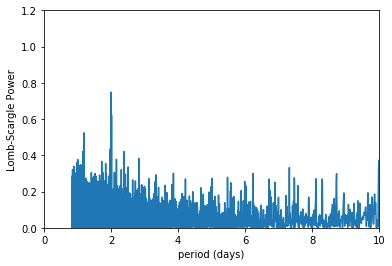

('actualperiod', 0.6666666666666666, 'measured period', 1.9999942486071474, 0.83410309926829251) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


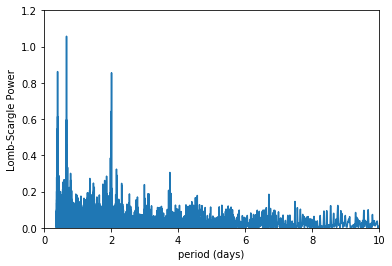

('actualperiod', 0.6666666666666666, 'measured period', 0.66666723516986026, 0.37163740518918909) 150
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


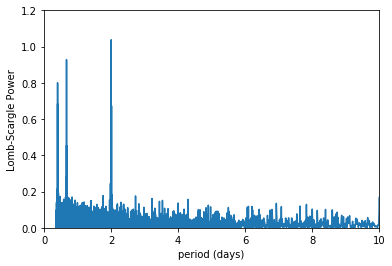

('actualperiod', 0.6666666666666666, 'measured period', 1.9999821367657937, 0.36590236645161317) 150
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


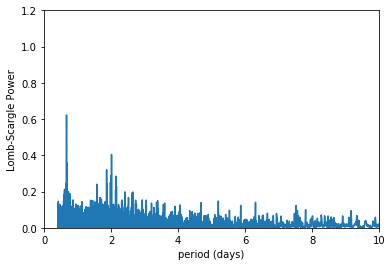

('actualperiod', 0.6666666666666666, 'measured period', 0.66667049453021421, 0.41372401652694546) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


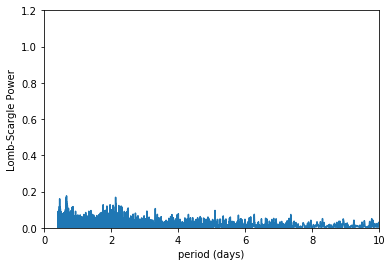

('actualperiod', 0.6666666666666666, 'measured period', 0.66667133651754107, 0.41015243664670648) 150


In [41]:
# actual frequency = frquency/100
lombScargleAuto([150],([23]*7),Nquist=100)
 # 40 background corresponing to R band at new moon, could be made more detailed?

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


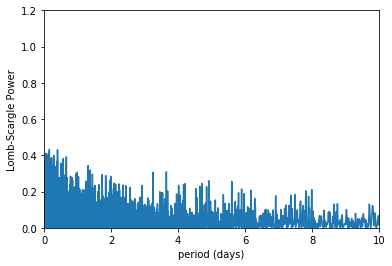

('actualperiod', 0.6666666666666666, 'measured period', 0.15332754725667441, 0.023012797875862051) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


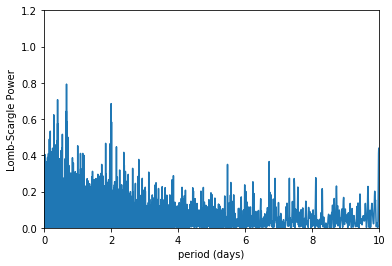

('actualperiod', 0.6666666666666666, 'measured period', 0.66666741911712968, 0.016682061985365849) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


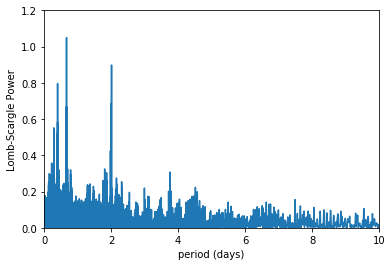

('actualperiod', 0.6666666666666666, 'measured period', 0.66667033808811071, 0.0074327481037837831) 150
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


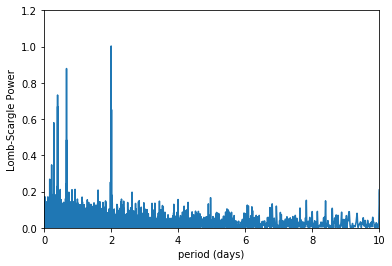

('actualperiod', 0.6666666666666666, 'measured period', 1.9999915404079784, 0.0073180473290322635) 150
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


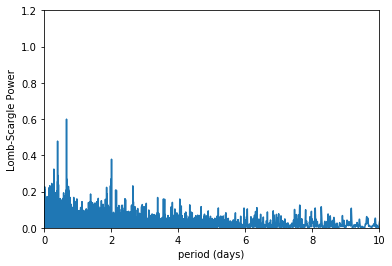

('actualperiod', 0.6666666666666666, 'measured period', 0.66666920798686735, 0.0082744803305389095) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


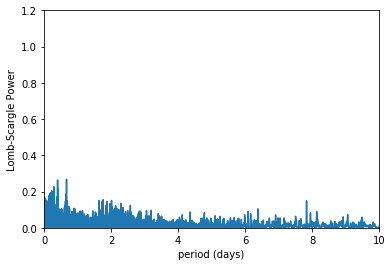

('actualperiod', 0.6666666666666666, 'measured period', 0.66666406918409271, 0.008203048732934131) 150


In [43]:
lombScargleAuto([150],([23]*7),Nquist=5000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


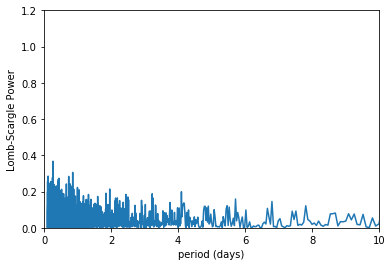

('actualperiod', 0.6666666666666666, 'measured period', 0.039991818032456251, 0.20507621832335324) 150
[(0.25942951365139783-0.0034923756062004746j), (0.25455474302951131-0.0034267526561895696j), (0.23239872578458559-0.0031284938610830521j), (0.36727207309461835-0.0049441253266112803j), (0.34438537182996232-0.0046360302449141187j), (0.22598824125767641-0.0030421975123345966j), (0.46049541759018353-0.0061990748104322037j), (0.36861479641875561-0.0049622007341356316j), (0.30279734504202427-0.004076182569065754j), (0.33548670196159686-0.0045162385637807596j)]
[(0.25942951365139783-0.0034923756062004746j), (0.25455474302951131-0.0034267526561895696j), (0.23239872578458559-0.0031284938610830521j), (0.36727207309461835-0.0049441253266112803j), (0.34438537182996232-0.0046360302449141187j), (0.22598824125767641-0.0030421975123345966j), (0.46049541759018353-0.0061990748104322037j), (0.36861479641875561-0.0049622007341356316j), (0.30279734504202427-0.004076182569065754j), (0.33548670196159686-0.

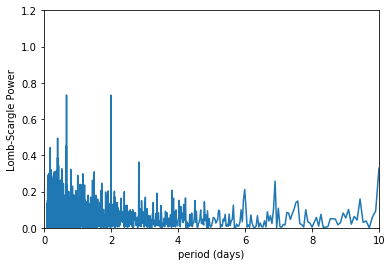

('actualperiod', 0.6666666666666666, 'measured period', 0.66667079813446495, 0.5753199468965513) 150
[(0.29233098666336693-0.0072769694164535222j), (0.31872971303868525-0.0079341105791443309j), (0.3303390798652977-0.0082231015215890775j), (0.27822455497113774-0.0069258192589854353j), (0.27452189915085218-0.0068336493748708269j), (0.22782715834344039-0.0056712813185687714j), (0.28011255663104145-0.0069728171174545193j), (0.33092488551258004-0.0082376839297966884j), (0.28823886799902515-0.0071751046681803425j), (0.30439262403589029-0.0075772186896285168j)]
[(0.29233098666336693-0.0072769694164535222j), (0.31872971303868525-0.0079341105791443309j), (0.3303390798652977-0.0082231015215890775j), (0.27822455497113774-0.0069258192589854353j), (0.27452189915085218-0.0068336493748708269j), (0.22782715834344039-0.0056712813185687714j), (0.28011255663104145-0.0069728171174545193j), (0.33092488551258004-0.0082376839297966884j), (0.28823886799902515-0.0071751046681803425j), (0.30439262403589029-0.00

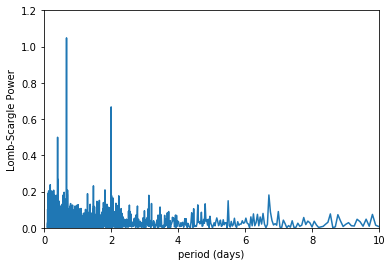

('actualperiod', 0.6666666666666666, 'measured period', 0.6666682694727345, 0.41705154963414626) 150
[(0.1720960919940103-0.011235217913470532j), (0.11991471239845765-0.0078285794245386408j), (0.15504029458296451-0.010121737657290308j), (0.19664705152939729-0.012838016542822734j), (0.16115938601268873-0.01052121985847704j), (0.22885915222336012-0.014940969413826475j), (0.13586998817014326-0.0088702126079966588j), (0.1756031254361741-0.011464173054148045j), (0.1631800924466264-0.010653140792075183j), (0.11638673267065858-0.0075982568147869431j)]
[(0.1720960919940103-0.011235217913470532j), (0.11991471239845765-0.0078285794245386408j), (0.15504029458296451-0.010121737657290308j), (0.19664705152939729-0.012838016542822734j), (0.16115938601268873-0.01052121985847704j), (0.22885915222336012-0.014940969413826475j), (0.13586998817014326-0.0088702126079966588j), (0.1756031254361741-0.011464173054148045j), (0.1631800924466264-0.010653140792075183j), (0.11638673267065858-0.0075982568147869431j)]

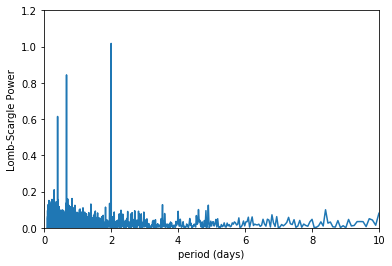

('actualperiod', 0.6666666666666666, 'measured period', 1.9999774349778623, 0.18581870259459457) 150
[(0.17910290938680851-0.0054505183955678325j), (0.12830201781088052-0.0039045290255803212j), (0.13616700290095976-0.0041438788276639991j), (0.20077159825755445-0.0061099470318875483j), (0.1145432242224764-0.003485816913023534j), (0.11580901322566331-0.0035243378185208173j), (0.11297252546057569-0.0034380168938895846j), (0.13300077003673008-0.0040475229921824894j), (0.10935026650601688-0.0033277831230763273j), (0.15226965532339504-0.0046339200198836439j)]
[(0.17910290938680851-0.0054505183955678325j), (0.12830201781088052-0.0039045290255803212j), (0.13616700290095976-0.0041438788276639991j), (0.20077159825755445-0.0061099470318875483j), (0.1145432242224764-0.003485816913023534j), (0.11580901322566331-0.0035243378185208173j), (0.11297252546057569-0.0034380168938895846j), (0.13300077003673008-0.0040475229921824894j), (0.10935026650601688-0.0033277831230763273j), (0.15226965532339504-0.0046

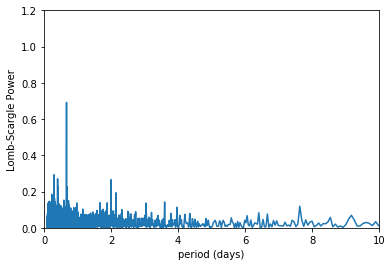

('actualperiod', 0.6666666666666666, 'measured period', 0.66667538344021893, 0.18295118322580659) 150
[(0.11782001044320201-0.00047438643884902009j), (0.12422822082445215-0.00050018823678403275j), (0.12204434087949588-0.00049139513766560216j), (0.13260926720528182-0.00053393339375248266j), (0.20636778322118415-0.00083091214647836292j), (0.19345741846359393-0.00077893029773673874j), (0.12185922968646432-0.00049064981232296292j), (0.14771870565958353-0.00059476951721217281j), (0.16489892341551859-0.00066394335524894404j), (0.17896833519862651-0.00072059195108068971j)]
[(0.11782001044320201-0.00047438643884902009j), (0.12422822082445215-0.00050018823678403275j), (0.12204434087949588-0.00049139513766560216j), (0.13260926720528182-0.00053393339375248266j), (0.20636778322118415-0.00083091214647836292j), (0.19345741846359393-0.00077893029773673874j), (0.12185922968646432-0.00049064981232296292j), (0.14771870565958353-0.00059476951721217281j), (0.16489892341551859-0.00066394335524894404j), (0.

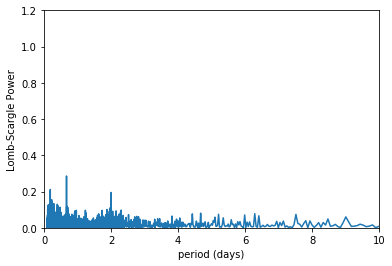

('actualperiod', 0.6666666666666666, 'measured period', 0.66666614554891046, 0.20686200826347273) 150
[(0.13623024930394362-0.010805656411533127j), (0.13763464864149502-0.01091705205812192j), (0.12884503702046182-0.010219868256044314j), (0.1441354142086641-0.011432686724355486j), (0.13417821528840507-0.010642890985866051j), (0.1292061641602805-0.010248512524213082j), (0.12721638987417538-0.010090685482260123j), (0.13985447257360503-0.011093126423595352j), (0.18691011846717823-0.014825536401164132j), (0.16745179693999299-0.013282120472306869j)]
[(0.13623024930394362-0.010805656411533127j), (0.13763464864149502-0.01091705205812192j), (0.12884503702046182-0.010219868256044314j), (0.1441354142086641-0.011432686724355486j), (0.13417821528840507-0.010642890985866051j), (0.1292061641602805-0.010248512524213082j), (0.12721638987417538-0.010090685482260123j), (0.13985447257360503-0.011093126423595352j), (0.18691011846717823-0.014825536401164132j), (0.16745179693999299-0.013282120472306869j)]
10

In [58]:
lombScargle([150],([23]*7),numsteps=10000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


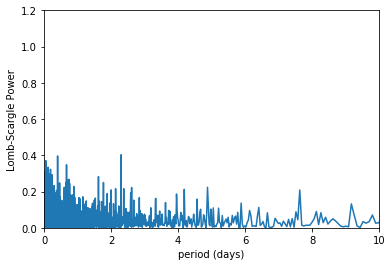

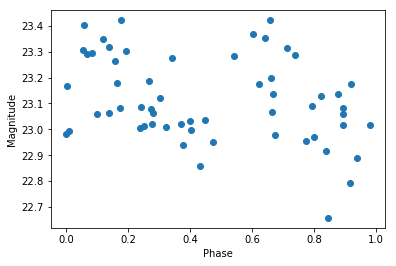

('actualperiod', 0.6666666666666666, 'measured period', 1.9890609159774093) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


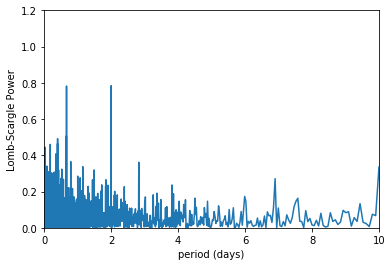

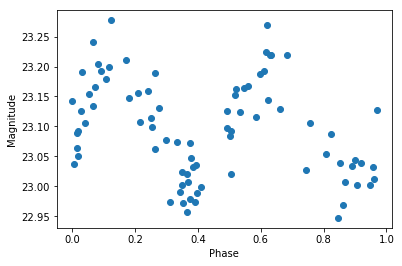

('actualperiod', 0.6666666666666666, 'measured period', 0.66667105806029403) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


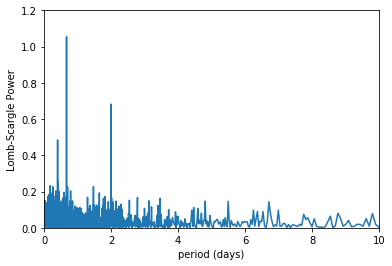

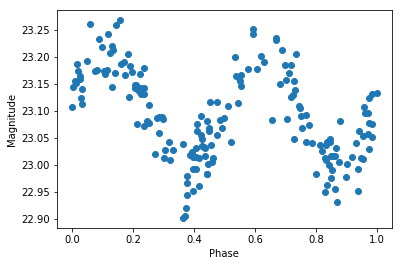

('actualperiod', 0.6666666666666666, 'measured period', 0.66667059666593531) 150
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


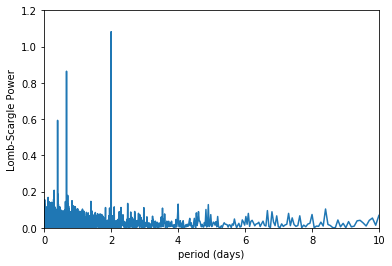

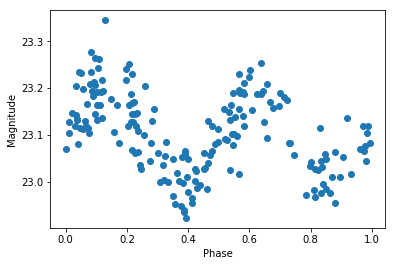

('actualperiod', 0.6666666666666666, 'measured period', 1.9999962422622317) 150
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


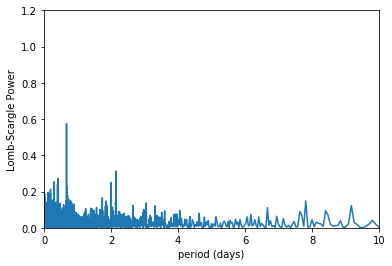

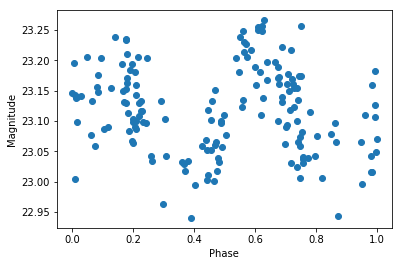

('actualperiod', 0.6666666666666666, 'measured period', 0.66667332494305631) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


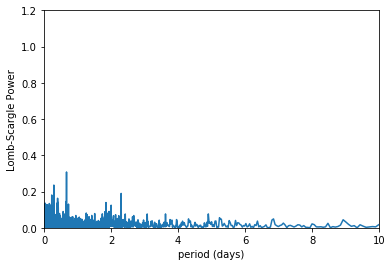

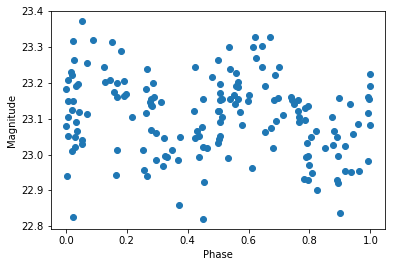

('actualperiod', 0.6666666666666666, 'measured period', 0.66665784016724228) 150


In [21]:
lombScargle([150],([23]*7),numsteps=100000)

In [30]:
lombScargle([150],([23]*7),numsteps=500000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
('actualperiod', 0.6666666666666666, 'measured period', 0.010955773274121046) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
('actualperiod', 0.6666666666666666, 'measured period', 2.0000082844402605) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
('actualperiod', 0.6666666666666666, 'measured period', 0.6

In [31]:
print(totpower)

[[(0.37103071276610977-0.007623479604672404j), (0.83773541049464162-0.029173638067033304j), (0.8090834791685505-0.0081645315951554328j), (0.8215672004901815+0.018707497451986459j), (0.52485677368732031-0.036270648754721427j), (0.30142773718987176-0.0042883206511260272j)]]


In [ ]:
lombScargle([150],([23]*7),numsteps=10000) 

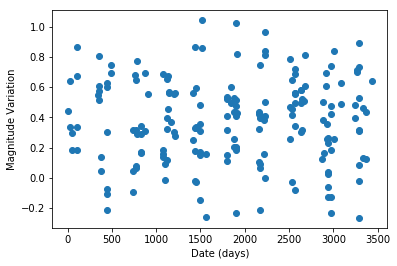

In [137]:
perfex = np.linspace(0, 3500, 3501)
#perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
#plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
#plt.xlim([2200, 2300])
plt.show()

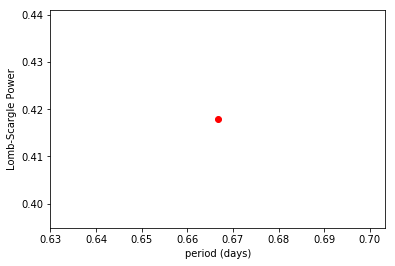

In [138]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()

In [45]:
def over9000(frequencyRange,objectmag,loopNo,modulationAmplitude=0.1,background=40,Nquist=5000,numsteps=20000): # frequency range and object mag in list
    global maxpower, powerperiod
#     powerperiod = []
    maxpower = [] # reset

    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    # loops over number filters
            for G in range(0, len(y[z])): # loops over number of obs
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(3,4):#(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
        for loop in range(0,loopNo):
            random.shuffle(date)
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            model.optimizer.period_range=(0.01, 10)
            maxpower.append(power.max())
#             LSperiod = model.best_period
#             powerperiod.append(LSperiod)
            
    

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


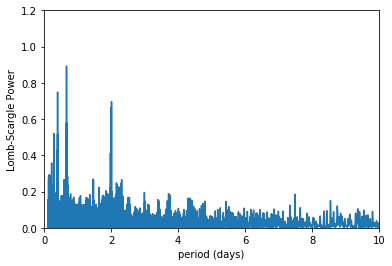

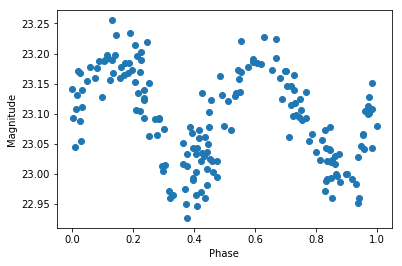

('actualperiod', 0.6666666666666666, 'measured period', 0.6666633565626654) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  

KeyboardInterrupt: 

In [65]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)
lombScargle([150],([23]*7),Nquist=300)
over9000([150],([23]*7),10000,Nquist=300)